We want to use (train) a Gaussian Process for regression analysis so that we can determin (by fitting) 

In [1]:
using CSV
using DataFrames
using PyPlot
# using StatsBase
using Statistics


using ScikitLearn # machine learning package
using ScikitLearn.CrossValidation: train_test_split
@sk_import gaussian_process : GaussianProcessRegressor
@sk_import gaussian_process.kernels : Matern

@sk_import inspection : permutation_importance
# @sk_import metrics : confusion_matrix

PyObject <function permutation_importance at 0x7f80f37448c8>

In [2]:
filename = joinpath(pwd(), "descriptors/cof_descriptors.csv")
descriptors = CSV.read(filename, DataFrame)
rename!(descriptors, "crystal_name" => "xtal")

# for some reason these ones aren't working... LOOk INTO IT
skip_for_now = ["07012N3_ddec.cif", "16290N3_ddec.cif", "21111N3_ddec.cif"]
[delete!(descriptors, findfirst(descriptors[:, "xtal"] .== skip_for_now[i])) for i in 1:length(skip_for_now)]

target_and_cost_data = CSV.read(joinpath(pwd(), "target_and_cost_data.csv"), DataFrame)

target_and_cost_data[1:5, :]

,xtal,henry_coeff,err_henry_coeff
,String,String,String
1,05000N2_ddec.cif,"[1.80109037955602, 1.651416583855947]","[1.80109037955602, 1.651416583855947]"
2,05001N2_ddec.cif,"[5.615571200847626, 5.291361399491628]","[5.615571200847626, 5.291361399491628]"
3,07000N2_ddec.cif,"[4.406490850448608, 4.244245433807373]","[4.406490850448608, 4.244245433807373]"
4,07001N2_ddec.cif,"[1.8438791513442994, 1.7389115810394287]","[1.8438791513442994, 1.7389115810394287]"
5,07002N2_ddec.cif,"[3.2536184151967364, 3.2702232837677]","[3.2536184151967364, 3.2702232837677]"


In [3]:
names(target_and_cost_data)

13-element Vector{String}:
 "xtal"
 "henry_coeff"
 "err_henry_coeff"
 "henry_elapsed_time"
 "henry_total_elapsed_time"
 "henry_selectivity"
 "err_henry_selectivity"
 "gcmc_uptake"
 "err_gcmc_uptake"
 "gcmc_pressure"
 "gcmc_elapsed_time"
 "gcmc_selectivity"
 "err_gcmc_selectivity"

Scikitlearn takes as input:

- a feature matrix X, which must be n_samples by n_features
- a target vector y, which must be n_samples long (of course)

In [4]:
x_cols = [name for name in names(descriptors) if name != "xtal"]
n_xtals = nrow(descriptors)

X = zeros(n_xtals, length(x_cols))
y = zeros(n_xtals)

for (i, row) in enumerate(eachrow(descriptors))
#     @assert descriptors[i, "xtal"] == target_and_cost_data[i, :xtal] 
    
    for (j, col_name) in enumerate(x_cols)
        X[i, j] = row[col_name] 
    end
    # need to normalize X
    
    y[i] = target_and_cost_data[i, :henry_selectivity] # Xe/Kr Selectivity
end
X # look at y too!

609×14 Matrix{Float64}:
  3.84928  0.2  4175.64  1049.37   0.0292303   …  0.00974344   0.0  0.0  0.0
 19.7302   0.6  3156.96   585.477  0.0204808      0.00227564   0.0  0.0  0.0
 26.1625   0.8  3407.23   458.054  0.0171524      0.00142936   0.0  0.0  0.0
  7.82083  0.4  2565.59  1100.22   0.037349       0.00466863   0.0  0.0  0.0
 14.8469   0.4  3345.75   703.114  0.0271906      0.00194218   0.0  0.0  0.0
  9.33026  0.7  5261.66   421.68   0.0149858   …  0.00239773   0.0  0.0  0.0
  9.94867  0.7  5452.36   383.117  0.0125929      0.00209882   0.0  0.0  0.0
 27.193    0.9  5190.06   171.075  0.00643935     0.000525661  0.0  0.0  0.0
 10.0414   0.6  5593.85   519.979  0.0156241      0.00175223   0.0  0.0  0.0
  4.7838   0.2  3845.42  1143.15   0.0374755      0.00468444   0.0  0.0  0.0
  7.51918  0.4  3597.55   988.327  0.0313415   …  0.00447735   0.0  0.0  0.0
  9.8332   0.5  3440.67   874.7    0.0265802      0.00443003   0.0  0.0  0.0
 13.0805   0.5  3172.89   756.001  0.0217047      0.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25);

In [6]:
# train on training data
kernel = Matern(nu=2.5, length_scale=0.25)
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=true)
gpr.fit(X_train, y_train)

PyObject GaussianProcessRegressor(kernel=Matern(length_scale=0.25, nu=2.5),
                         normalize_y=True)

In [7]:
gpr.get_params() # why isn't length scale being optimized?

Dict{Any, Any} with 10 entries:
  "normalize_y"                 => true
  "optimizer"                   => "fmin_l_bfgs_b"
  "alpha"                       => 1.0e-10
  "kernel__length_scale_bounds" => (1.0e-5, 100000.0)
  "kernel"                      => PyObject Matern(length_scale=0.25, nu=2.5)
  "kernel__nu"                  => 2.5
  "random_state"                => nothing
  "kernel__length_scale"        => 0.25
  "n_restarts_optimizer"        => 0
  "copy_X_train"                => true

In [8]:
# get predictions on test data
y_pred = gpr.predict(X_test)

153-element Vector{Float64}:
 0.945288865549937
 0.945288865549937
 0.945288865549937
 0.945288865549937
 0.945288865549937
 0.945288865549937
 0.945288865549937
 0.945288865549937
 0.945288865549937
 0.945288865549937
 0.945288865549937
 0.945288865549937
 0.945288865549937
 ⋮
 0.945288865549937
 0.945288865549937
 0.945288865549937
 0.945288865549937
 0.945288865549937
 0.945288865549937
 0.945288865549937
 0.945288865549937
 0.945288865549937
 0.945288865549937
 0.945288865549937
 0.945288865549937

In [9]:
# compute RMSE, R2 on test data
rmse = sqrt(mean((y_test - y_pred).^2))
r2 = gpr.score(X_test, y_test)

-3.3089906474437214e-5

In [10]:
# permutation importance
feature_importances = permutation_importance(gpr, X_test, y_test)

Dict{Any, Any} with 3 entries:
  "importances_std"  => [3.14309e-11, 1.28509e-9, 1.4569e-7, 1.77636e-16, 5.351…
  "importances_mean" => [9.0497e-9, 1.17675e-9, 3.79318e-8, 9.06541e-9, 6.77103…
  "importances"      => [9.06541e-9 9.06541e-9 … 9.06541e-9 9.06541e-9; 3.40812…

## Parity Plot

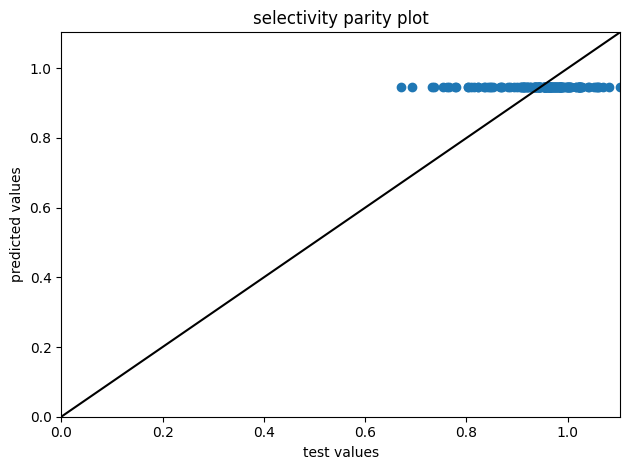

In [11]:
figure()

xmax = maximum(max.(y_test, y_pred))
x = range(0.0, stop=xmax, length=length(y_test))
y = x
plot(x, y, color="k")

scatter(y_test, y_pred)

xlim([0.0, xmax])
ylim([0.0, xmax])

title("selectivity parity plot")
xlabel("test values")
ylabel("predicted values")

tight_layout()